### 데이터 타입 기록###
A. 데이터 설명

본 대회에서는 한국수력원자력(주)에서 제공받은 원자력 발전소 모사 데이터 및 실제 데이터가 제공됩니다. 

주어진 10분 사이에 발전소의 상태가 변하며 변하기 전 발전소 상태를 상태_A, 변한 후 상태를 상태_B라고 할 때 

데이터를 기반으로 상태_B를 판단하는 것이 대회의 목적입니다. 모든 데이터는 같은 상태 (상태_A)에서 시작합니다. 



모사 데이터는 0초에서 15초 사이에 상태가 변하기 시작합니다. 모든 데이터가 숫자로 이루어져 있습니다. 

반면 실제 데이터는 10초에 상태가 변하기 시작합니다. 실제 데이터에는 Bad, CLOSE, Equip Fail, No Data, Normal, OFF, ON, OPEN, System.Char[] 등 문자열 데이터를 포함하고 있으며 결측치가 있을 수 있습니다. 



훈련 데이터로는 10분 데이터가 주어지며 테스트 데이터로는 1분 간 데이터가 주어집니다. 즉 1분 데이터만 사용하여 평가합니다. 



B. 파일 설명

1. train.zip(9.81GB) : 훈련 데이터가 포함된 zip 파일입니다.

2. test.zip(879MB) : 테스트 데이터가 포함된 zip 파일입니다.

   train.zip, test.zip 내 파일이름은 해당되는 고유한 번호 (id) 로 되어 있습니다. train과 test의 id는 중복되지 않습니다.

3. train_label.csv(6.78KB) : 훈련데이터의 id (파일 이름)에 해당되는 상태_B를 정리한 파일입니다. 

4. sample_submission.csv(283KB) : 제출 형식과 동일한 샘플 데이터 입니다.

5. additional_data.zip(13.9MB) : 실제 발전소 운전 데이터 입니다. 참고자료로 주어지는 파일입니다. (컬럼은 train 및 test 데이터와 같습니다.)



데이터 파일 컬럼에 대한 설명은 아래와 같습니다.

time : 발전소 운전 경과 시간 입니다. 단위는 초 입니다.

V0000~V5120 : 발전소 운영 중 측정되는 변수 입니다. 비식별화 되어 제공됩니다.

O 코드 관련

1) 입상자는 코드 제출 필수. 제출 코드는 예측 결과를 리더보드 점수로 복원할 수 있어야 함

2) 코드 제출시 확장자가 R user는 R or .rmd. Python user는 .py or .ipynb

3) 코드에 ‘/data’ 데이터 입/출력 경로 포함 제출

4) 전체 프로세스를 일목요연하게 정리하여 주석을 포함하여 하나의 파일로 제출

5) 모든 코드는 오류 없이 실행되어야 함(라이브러리 로딩 코드 포함되어야 함).

6) 코드와 주석의 인코딩은 모두 UTF-8을 사용하여야 함 

## metric
평가 지표는 Log Loss를 사용합니다.

In [1]:
import numpy as np
import pandas as pd

from utils import load_eda_statistic_pd,reduce_mem_usage

import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import dill as pickle

from catboost import Pool

In [2]:
train = pd.read_csv("data/train/0.csv")
target = pd.read_csv("data/train_label.csv")
test = pd.read_csv("data/test/828.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
print("{} observations and {} features in {} train set.".format(train.shape[0],train.shape[1], len(os.listdir("data/train"))))
print("{} observations and {} features in {} test set.".format(test.shape[0],test.shape[1],len(os.listdir("data/test"))))
print("train : test row ratio {} and file {}".format(train.shape[0] / test.shape[0], len(os.listdir("data/train"))/len(os.listdir("data/test"))))

600 observations and 5122 features in 828 train set.
60 observations and 5122 features in 720 test set.
train : test row ratio 10.0 and file 1.15


### Issue:
- column 수 많음 -> 과적합
- train 을 모델에 어떻게 넣을 것인지  
ex1) train 파일 827개 붙이기  
ex2) 600 개마다 압축해서 1개씩 row추출 -> new dataset 만들기 shape(827, 1)  
- train, test 분포 같은지 확인  


In [3]:
target.head()

,id,label
0,0,110
1,1,29
2,2,111
3,3,176
4,4,130


In [4]:
train.head()

,time,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,...,V5111,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120
0,0,30.486806,8.682230,8.736399,8.691251,8.711798,204.576461,201.196818,-1.213967e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,127.58,112.263,-0.264703,85.4,-0.004474
1,1,30.460030,8.784153,8.691244,8.706254,8.716143,194.222395,169.979333,-2.279681e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,0.00,0.000,0.000014,85.4,0.000000
2,2,30.475103,8.812022,8.697733,8.721917,8.681361,193.078139,160.719360,-1.586760e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,0.00,0.000,-0.000013,85.4,0.000000
3,3,30.455413,8.908323,8.712004,8.723829,8.724655,207.644178,232.675873,-4.016423e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,0.00,0.000,0.000019,85.4,0.000000
4,4,30.472642,8.815620,8.702882,8.722939,8.702341,186.112451,160.829340,8.676680e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,0.00,0.000,-0.000008,85.4,0.000000


### 정리
- 5121개의 column이 Anonymized 된 binary classifiacation, multivarate timeseries  
모든 변수가 timeseries인 상태, iid 기반 모델 사용불가, 중요 변수를 어떻게 선택할지
- 5122개의 column / 600 * 827 개의 row 
- train , test 는 모사데이터 => 인공 데이터인경우 정규분포 기반 모델 잘통함 QDA, GMM 등등

In [5]:
train.info()
print("\n")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 5122 entries, time to V5120
dtypes: float64(5121), int64(1)
memory usage: 23.4 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 5122 entries, time to V5120
dtypes: float64(5121), int64(1)
memory usage: 2.3 MB


- int 인 변수들도 float으로 되어 있음 => 정리 필요

In [6]:
eda = load_eda_statistic_pd("eda.pkl",train)

In [7]:
eda["isnull_table"].sum(axis=0)

0

- 모든 column 결측치 없음

In [ ]:
train,_ = reduce_mem_usage(train)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 5122 entries, time to V5120
dtypes: float32(2434), int8(23), uint16(8), uint8(2657)
memory usage: 7.1 MB



- 소수 : 32개
- -127 ~ 128 : 23개
- 128 이상 자연수 : 8개
- 0 ~ 255 : 2657개

### 0번 데이터셋 eda
상태 A : 0 , 상태 B : 1 로 Y 값을 training set 에 삽입 후 line chart

In [10]:
def insert_label(train, label, n = 0):
    """
    train dataset 1개(600 rows) 에 0,1 label 삽입하는 함수
    
    args :
        n -- (int) nth training set
        train -- (pd.DataFrame) one training set , shape (600,5122)
        label -- (pd.DataFrame) Y label, shape (828, 1)
    return
        merged_train -- (pd.DataFrame) label added train set, shape (600, 5123)
    """
    merged_train = train.copy()
    B = int(label["label"][label['id'] == n])
    y = np.zeros(len(train))
    y[B:] = 1
    merged_train["target"]  = y
    return merged_train

In [11]:
merged_train = insert_label(train,target)

In [12]:
def plot_feature_linechart(df, features, target, save = False, filename = ""):
    """
    feature들의 linechart 그려주는 함수
    argument:
        df - (pd.dataframe) DataFrame
        features - 그릴 feature 들
    """
    ntarget = df[target].value_counts().keys().values #(string np.array) target feature의 class 확인
    subdf = [df.loc[df[target] == label] for label in ntarget] #(df list) df grouped by target, ntarget key 순서 

    i = 0
    plt.figure()
    fig, ax = plt.subplots(8,8,figsize=(24,30))

    for feature in features:
        i += 1
        plt.subplot(8,8,i)
        for _i,label in enumerate(ntarget):
            plt.plot(subdf[_i][feature])
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=13, pad=0)
        plt.tick_params(axis='y', which='major', labelsize=10)
        #plt.legend()
    if save == True:
        plt.savefig(filename)

<Figure size 432x288 with 0 Axes>

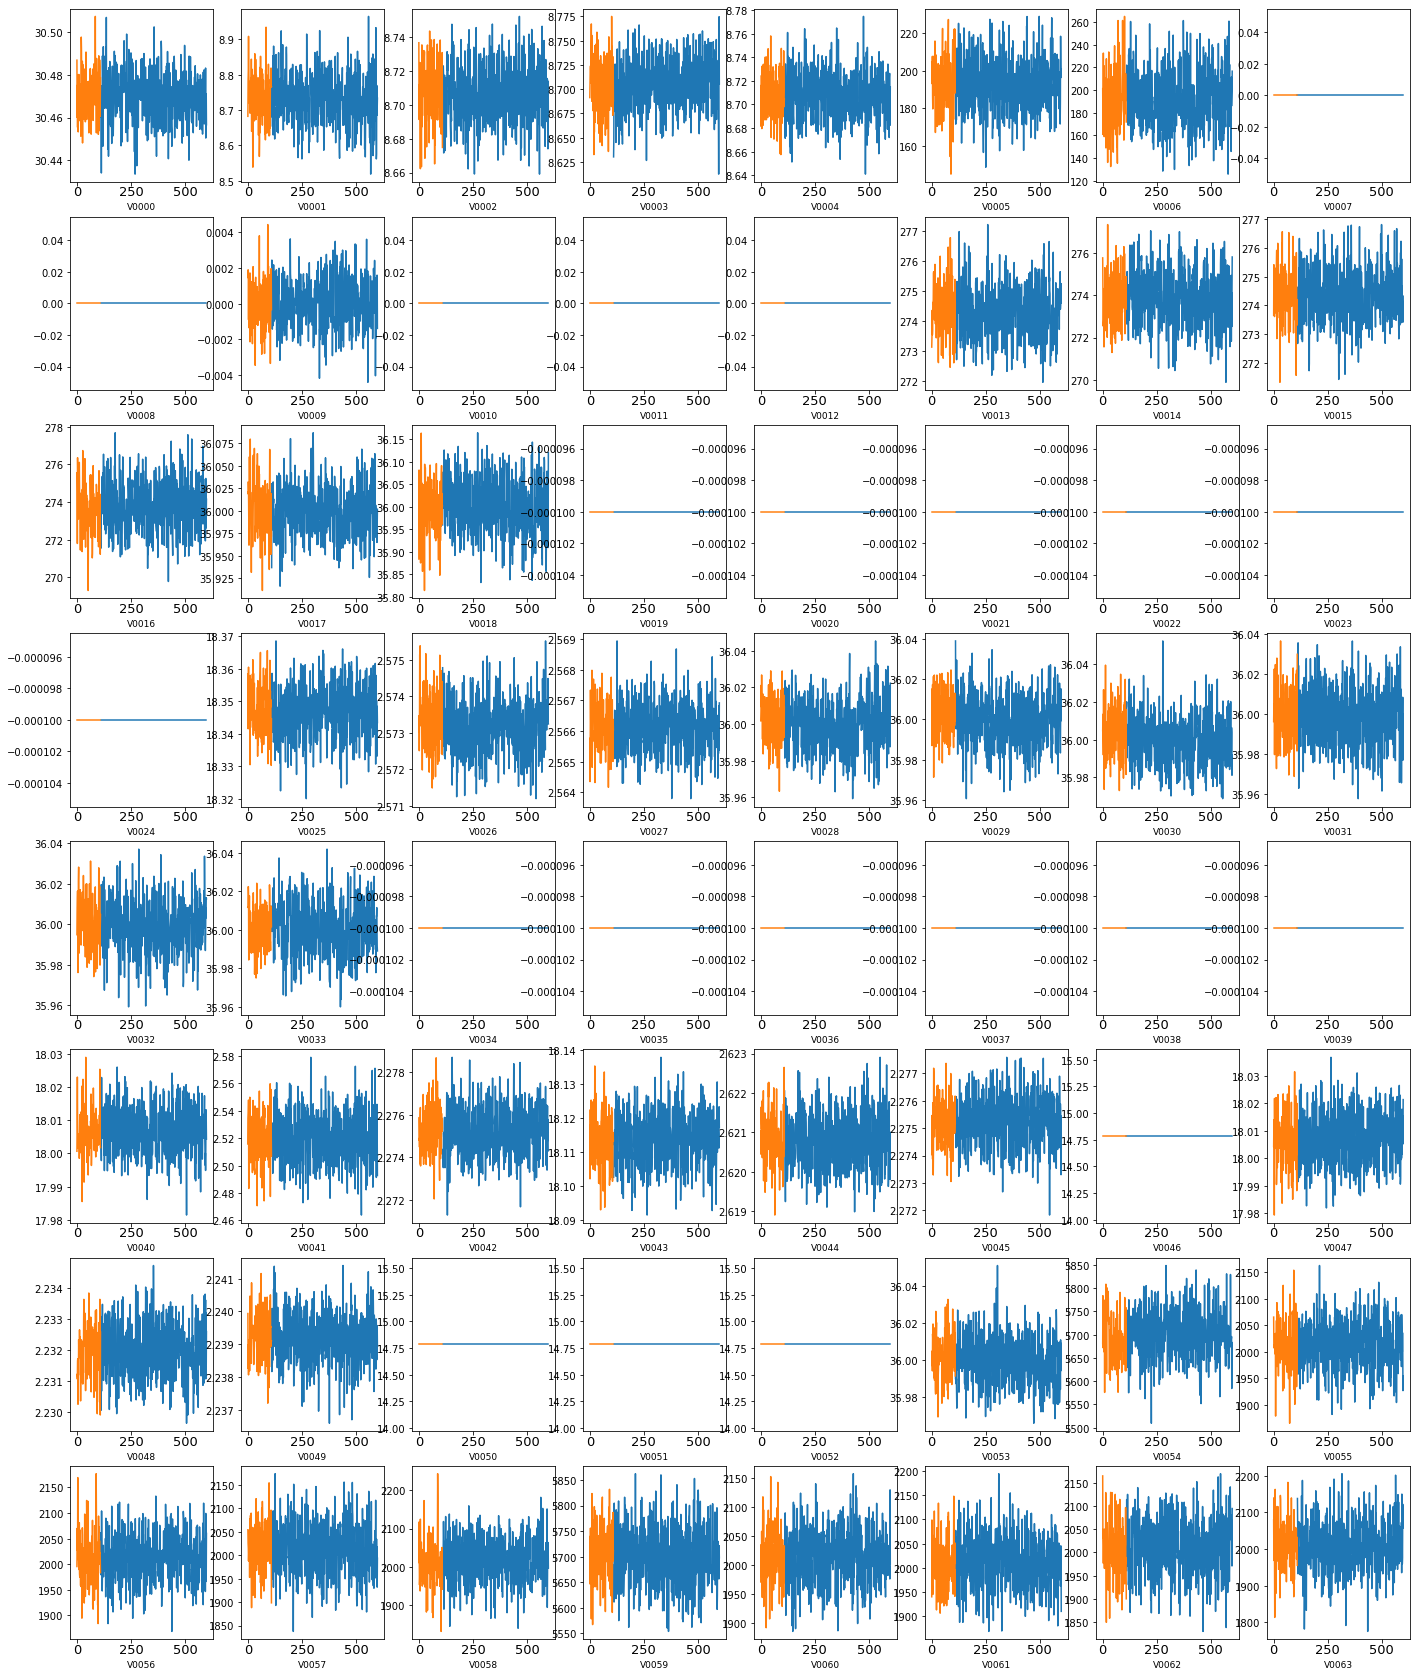

In [13]:
features = train.columns[1:65]
plot_feature_linechart(merged_train, features, 'target')

<Figure size 432x288 with 0 Axes>

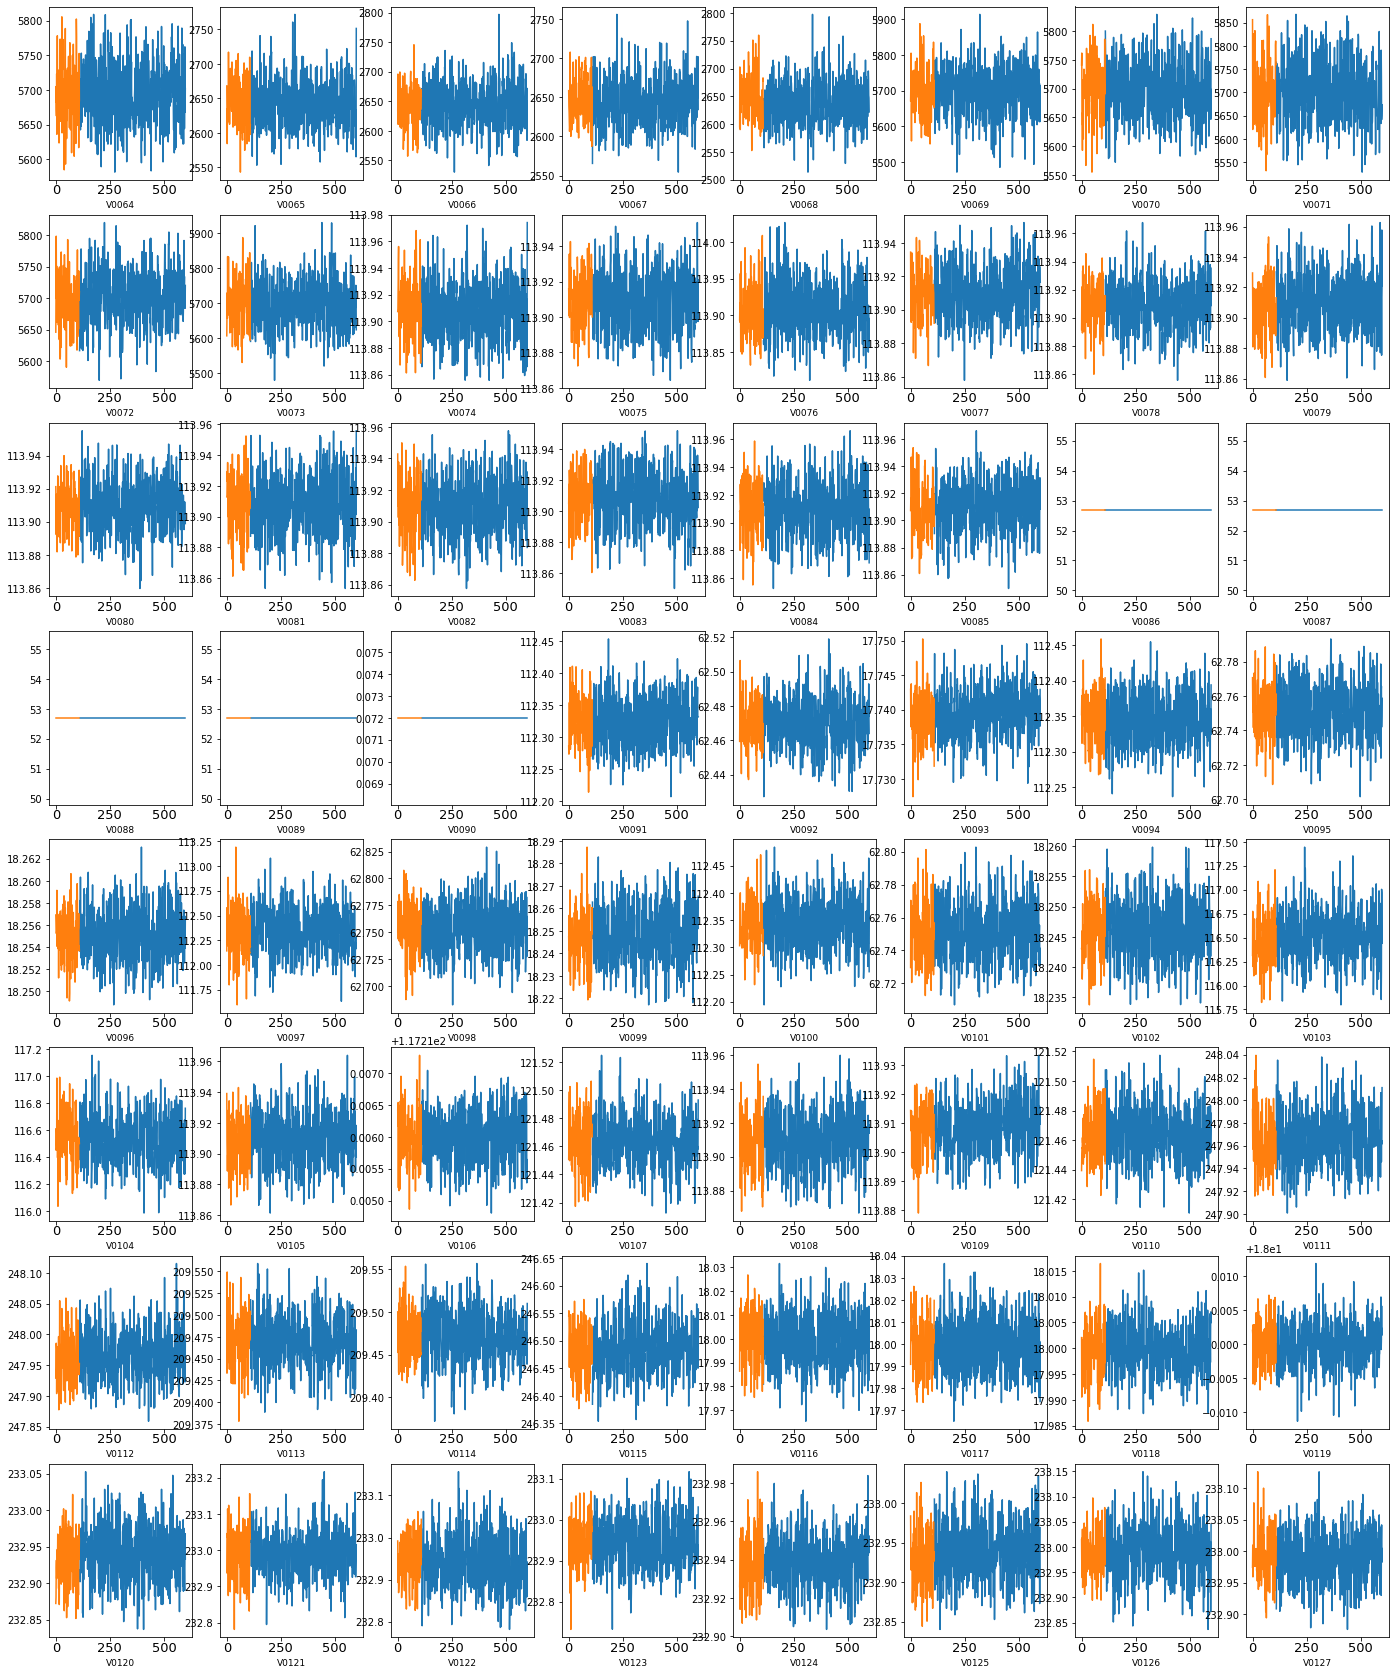

In [14]:
features = train.columns[1+ 64*1:65 + 64*1]
plot_feature_linechart(merged_train, features, 'target')

<Figure size 432x288 with 0 Axes>

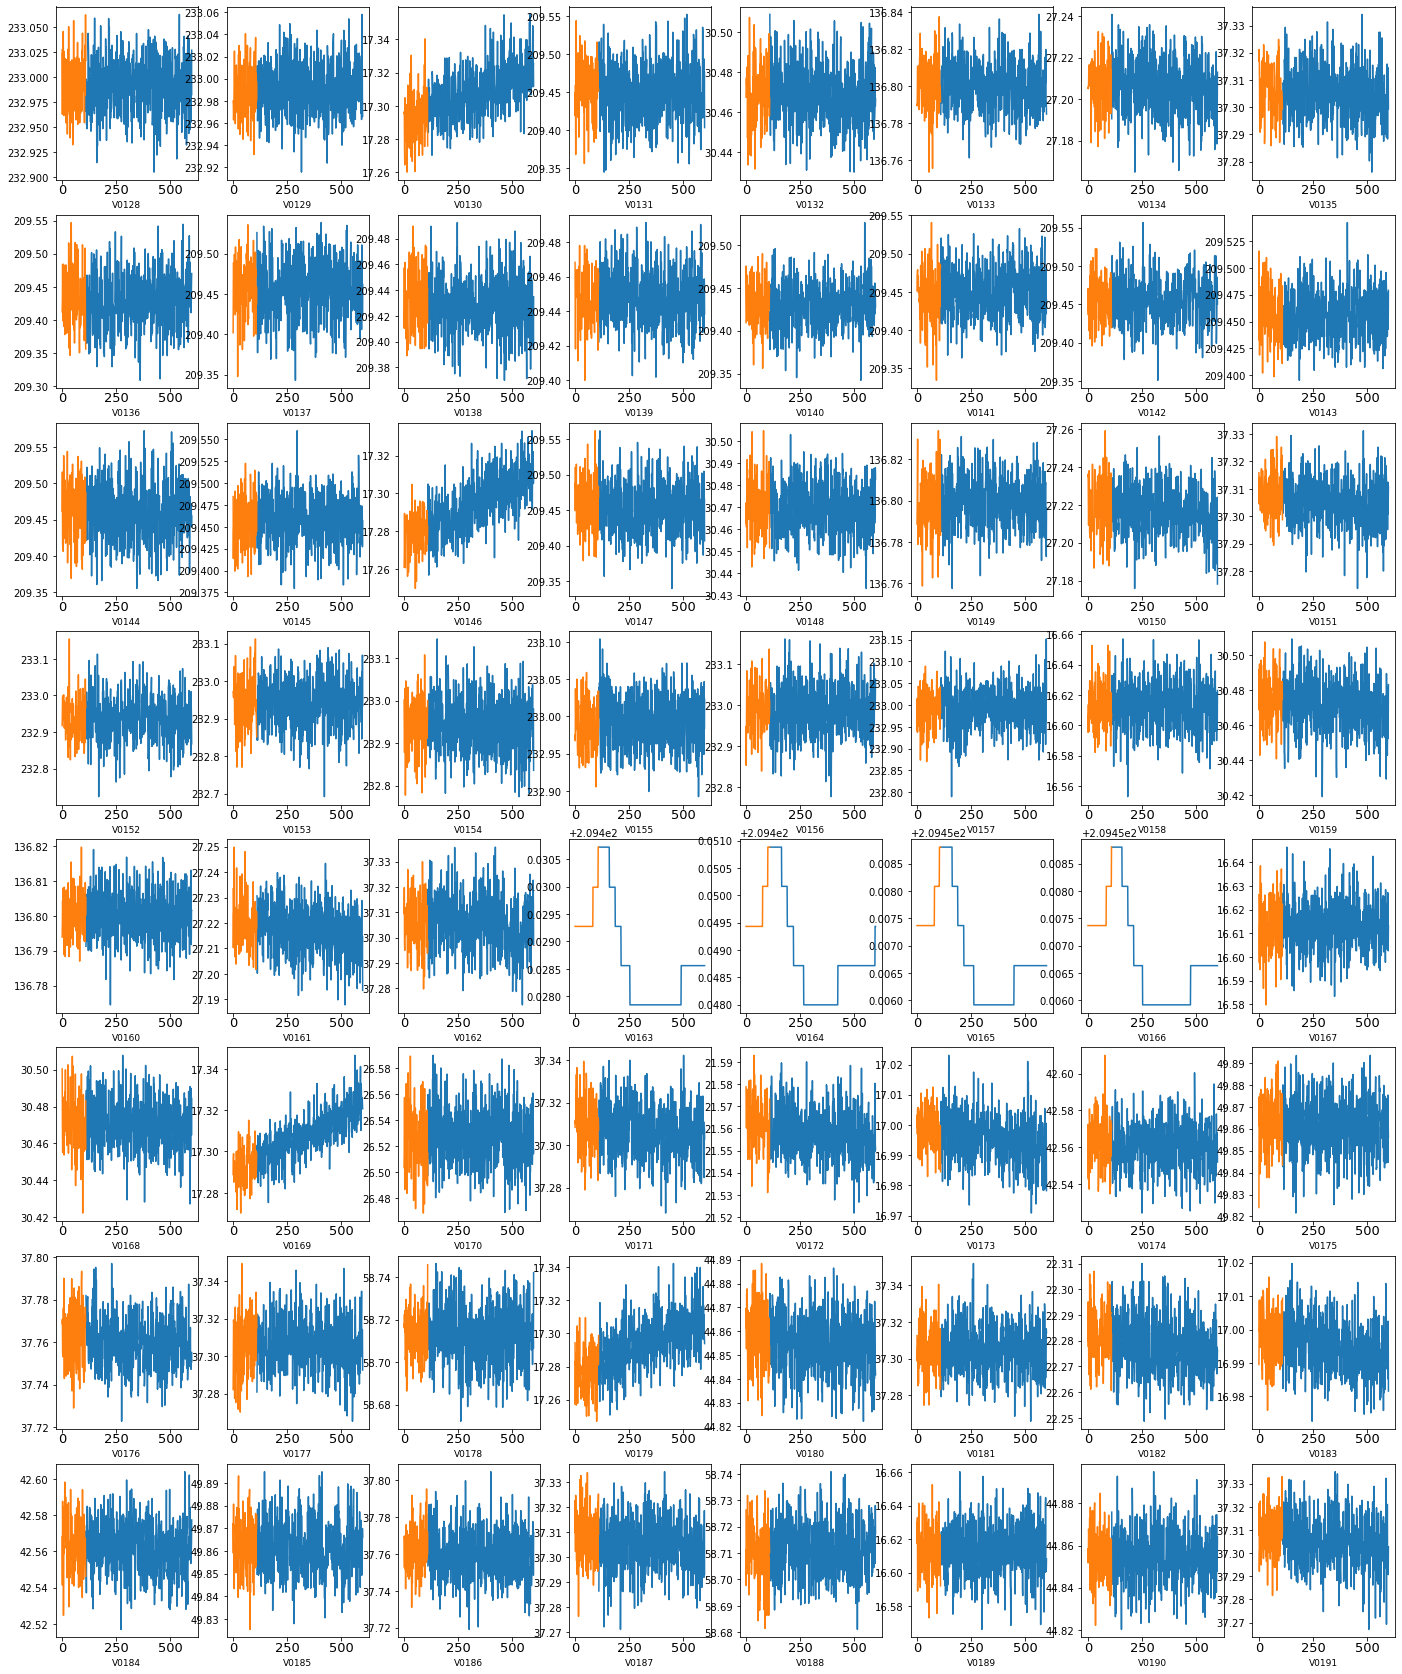

In [15]:
features = train.columns[1+ 64*2:65 + 64*2]
plot_feature_linechart(merged_train, features, 'target')

<Figure size 432x288 with 0 Axes>

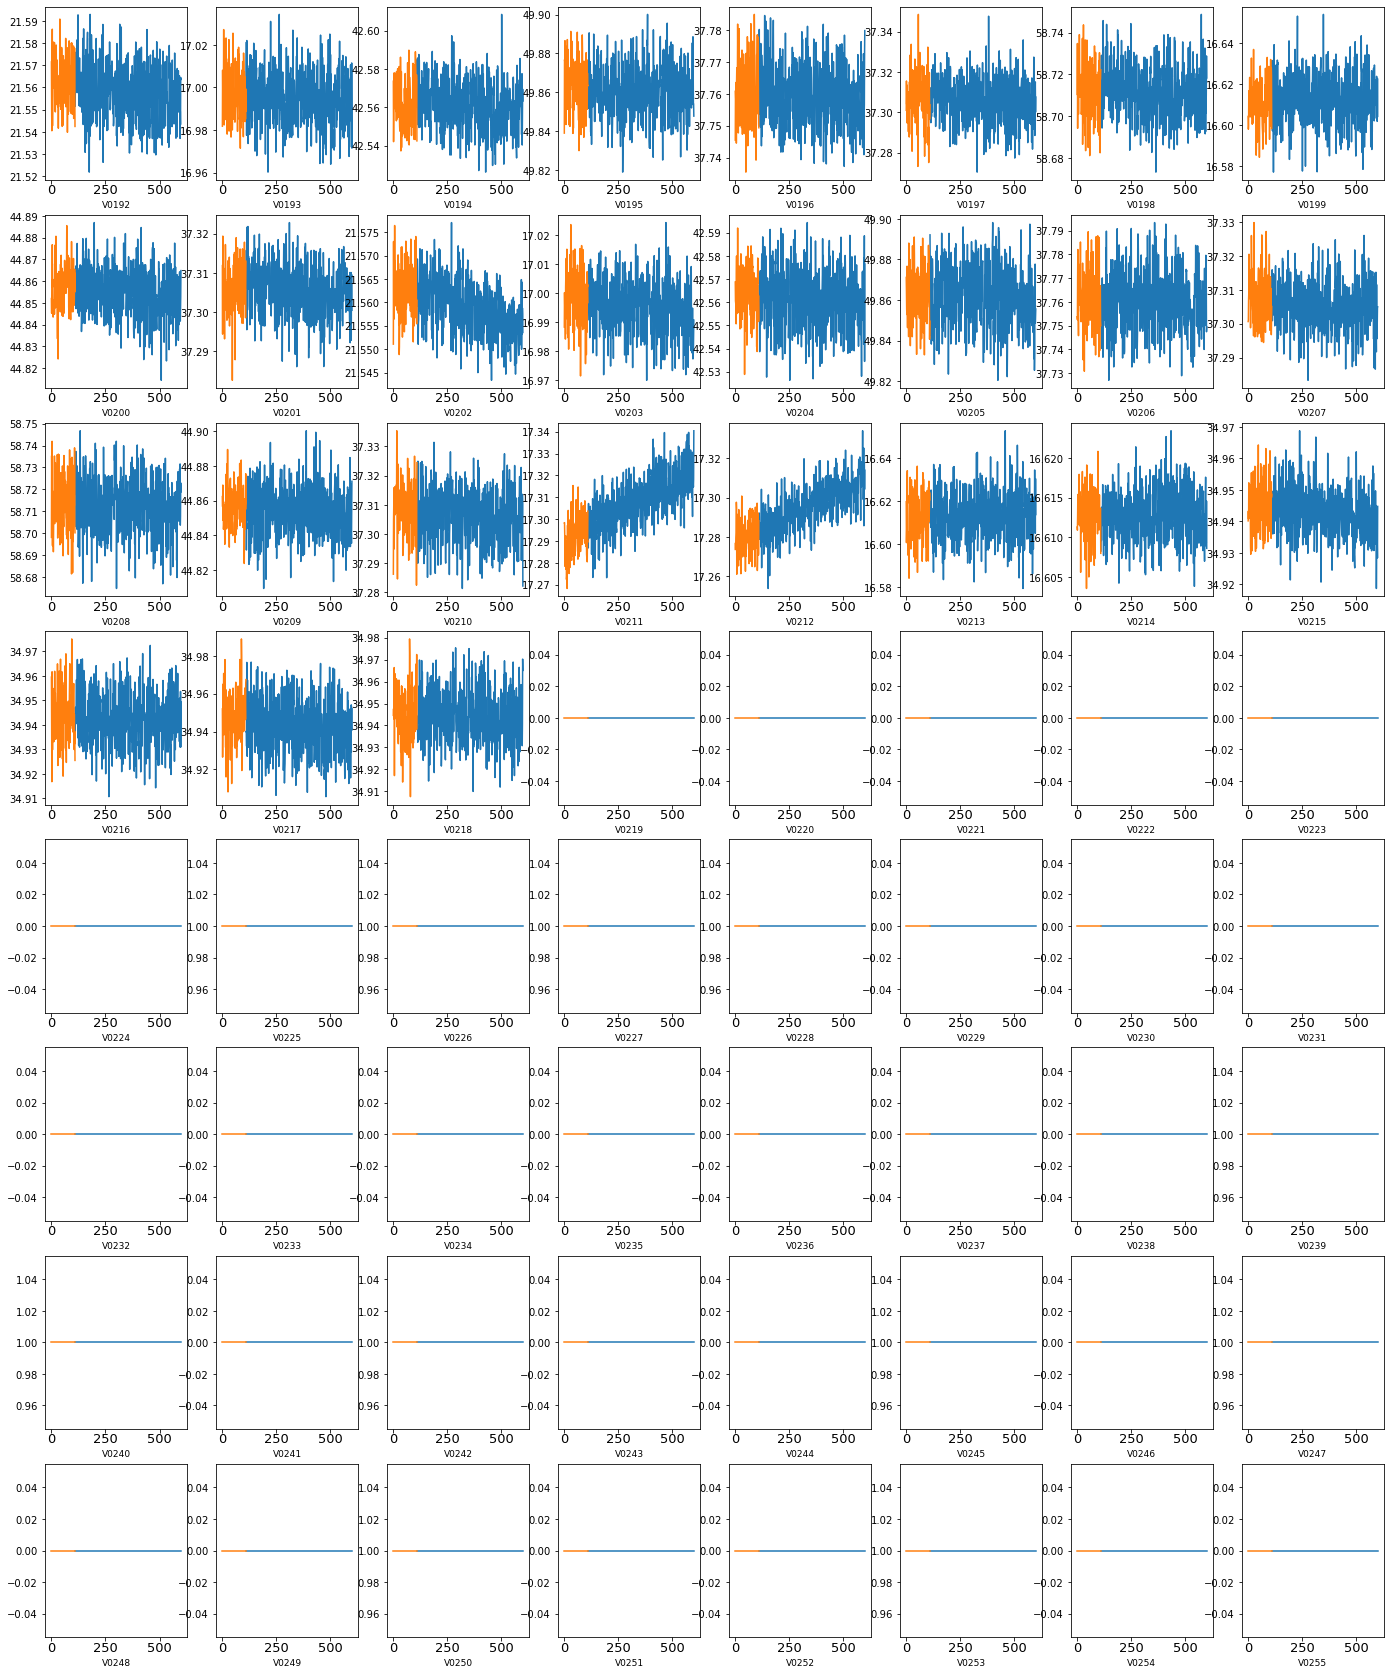

In [16]:
features = train.columns[1+ 64*3:65 + 64*3]
plot_feature_linechart(merged_train, features, 'target')

### Line chart 정리
- 변화가 미미한 feature :ex)V007, 8, 10, 12...
- 상태 변화시에 두드러지는 등락을 보이는 feature :ex)163,164,165,166..
- 증가추세를 보이는 feature :ex) 130,169,179 ...
- 5122 개의 column 그래프는 너무 많으므로 파일 한곳에 png 저장 필요

In [17]:
#for i in range(81):
#    filename = "eda/linechart/" + str(i) + ".png"
#    features = train.columns[1 + 64*i :65 + 64*i]
#    plot_feature_linechart(merged_train, features, 'target',True, filename)

### 변수선택 방법
- variance treshold? pca? 
- 시계열로 보지 말고 y를 각 상태에서의 binary classification으로 보고 iid 모델 적용해도 되지 않을까?
    - 각 변수들은 초기 상태에 의존??
        - 의존한다면 test set 파일마다 비슷한 분포의 training set을 골라서 그 training set만 학습, 적용
        - 혹은 초기상태 값을 모두 파일마다 뺀다음에 training?
        => 초기 상태에 의존한다는 점을 어떻게 알 수 있을까?
- 인공데이터인점을 이용할 수 없을까? 
    - normal 분포 활용 방안?

In [ ]:
os.listdir("data/train")

In [ ]:
#for i in range(10):
    #train = pd.read_csv("data/train/" + i + ".csv")
    #merged_train = insert_label(train,target)
    #features = train.columns[1:65]
    
    #plt.savefig(filename)#